<a href="https://colab.research.google.com/github/JiujiaZ/restless_bandit_basics/blob/main/run.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Some quick experiments to compare whittle index policy and random policy for a restless bandits, where each arm is a MDP.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

!git clone https://github.com/JiujiaZ/restless_bandit_basics
%cd /content/restless_bandit_basics/

Mounted at /content/drive
Cloning into 'restless_bandit_basics'...
remote: Enumerating objects: 42, done.
remote: Counting objects: 100% (42/42), done.
remote: Compressing objects: 100% (31/31), done.
remote: Total 42 (delta 17), reused 23 (delta 8), pack-reused 0
Receiving objects: 100% (42/42), 36.59 KiB | 4.57 MiB/s, done.
Resolving deltas: 100% (17/17), done.
/content/restless_bandit_basics


In [3]:
import numpy as np
from matplotlib import pyplot as plt

from tools import *
from models import Restless_Bandit
from train import *


#### Assume knowing exact transition

WI winning over random policy

In [11]:
n_arms = 100
n_states = 5
n_transitions = 10
K = 2
R = np.array([0, 1, 0, 0, -1])

transitions_indx = np.random.choice(n_transitions, size = n_arms)

transitions = np.zeros((n_arms, 2, n_states, n_states))

for i in range(n_transitions):
    transitions[transitions_indx == i] = random_transitions(n_actions = 2, n_states = n_states)

init_states = np.zeros((n_arms, n_states))
indx = np.random.choice(n_states, size = n_arms)
init_states[np.arange(len(indx)), indx] = 1

rb = Restless_Bandit(transitions = transitions, initial_states = init_states, R = R)

In [ ]:
# run with multiple trials with the same initial, parameters
n_trials = 10
WI_reward = list()
random_reward = list()

for i in range(n_trials):
    print('trail number:', i+1)

    rb.reset()
    WI_reward.append(WI_train(rb, R, episode = 1000, K = K ))

    rb.reset()
    random_reward.append(random_train(rb, episode = 1000, K = K ))

trail number: 0
trail number: 1
trail number: 2
trail number: 3
trail number: 4
trail number: 5
trail number: 6
trail number: 7
trail number: 8
trail number: 9


In [13]:
WI_mean = np.array(WI_reward).mean(axis = 0)
WI_std = np.array(WI_reward).std(axis = 0)

random_mean = np.array(random_reward).mean(axis = 0)
random_std = np.array(random_reward).std(axis = 0)

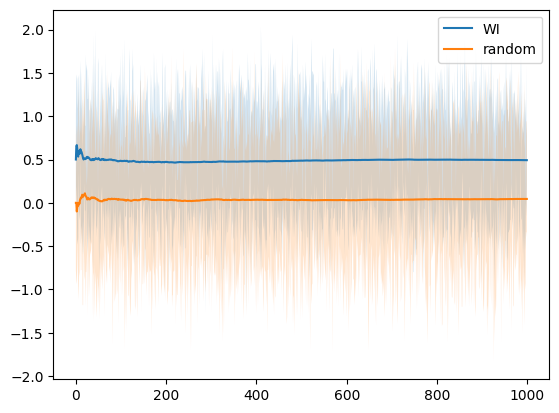

In [14]:
plt.plot(np.cumsum(WI_mean)/(np.arange(len(WI_mean))+1), label = 'WI')
plt.plot(np.cumsum(random_mean)/(np.arange(len(random_mean))+1), label = 'random')

plt.fill_between(np.arange(len(WI_mean)), WI_mean-WI_std, WI_mean+WI_std, alpha=0.2)
plt.fill_between(np.arange(len(random_mean)), random_mean-random_std, random_mean+random_std, alpha=0.2)

plt.legend()

## Assuming transition matrix is noisy to user.
We also assume true transition matrix stays the same throughout the game.

Experiment protocol:

1.   There is a ground truth transition matrix to each arm $i$ as $p_i(a, s, s')$ not visible to the user
2.   At the beginning of the game, a noisy $\hat{p}_i(a, s, s')$ is given to the user
3. The user believe $\hat{p}_i(a, s, s')$ is the correct transition dynamics, and will use this.

Generation of $\hat{p}_i(a, s, s')$:

first we know $\sum_{s'} \hat{p}_i(a, s, s') = 1, \forall a, s $, it make sense to pertubate the probability vector for a fixed $a, s$. For each arm:

*   Fix $a, s$, we have a probability vector $p_i(A=a, S=s, S)$
*   sample each cooidinate of vector $\epsilon$ from $N(0, \sigma)$.
*   $\hat{p}_i(A=a, S=s, S) \propto p_i(A=a, S=s, S) + \epsilon $
*   then we renormalize $\hat{p}_i$










In [47]:
# pertubation variance:
sigma = 1e-1

noisy_WI_reward = list()

for i in range(n_trials):
    print('trail number:', i+1)

    # ground truth transition provided to bandit model
    # same parameters, initial start as above
    rb.reset()

    # noisy transitions used for WI computation
    perturbed_transitions = np.zeros_like(transitions)
    for n in range(n_arms):
        perturbed_transitions[n,:,:,:] = noisy_transitions(transitions[n], sigma)
    noisy_WI_reward.append(WI_train(rb, R, transitions = perturbed_transitions, episode = 1000, K = K ))


trail number: 1
trail number: 2
trail number: 3
trail number: 4
trail number: 5
trail number: 6
trail number: 7
trail number: 8
trail number: 9
trail number: 10


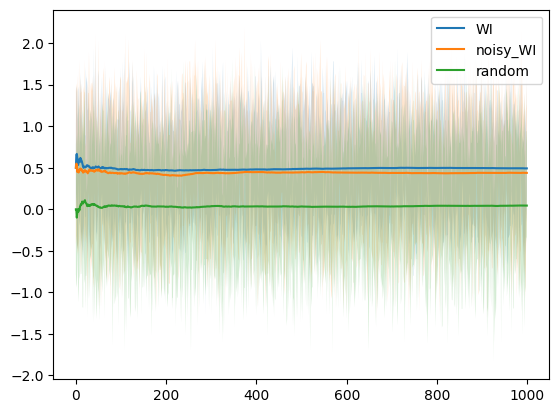

In [48]:
noisy_WI_mean = np.array(noisy_WI_reward).mean(axis = 0)
noisy_WI_std = np.array(noisy_WI_reward).std(axis = 0)

plt.plot(np.cumsum(WI_mean)/(np.arange(len(WI_mean))+1), label = 'WI')
plt.plot(np.cumsum(noisy_WI_mean)/(np.arange(len(noisy_WI_mean))+1), label = 'noisy_WI')
plt.plot(np.cumsum(random_mean)/(np.arange(len(random_mean))+1), label = 'random')

plt.fill_between(np.arange(len(WI_mean)), WI_mean-WI_std, WI_mean+WI_std, alpha=0.2)
plt.fill_between(np.arange(len(noisy_WI_mean)),
                 noisy_WI_mean-noisy_WI_std, noisy_WI_mean+noisy_WI_std, alpha=0.2)
plt.fill_between(np.arange(len(random_mean)), random_mean-random_std, random_mean+random_std, alpha=0.2)

plt.legend()